In [161]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import DeepLearningBase as dp
from itertools import *

file_path_gender = "gender_submission.csv"
file_path_train = "train.csv"
file_path_test = "test.csv"


df_gender = pd.read_csv(file_path_gender)
df_train = pd.read_csv(file_path_train).set_index("PassengerId", drop=True)
df_test = pd.read_csv(file_path_test).set_index("PassengerId", drop=True)


In [162]:
def replace_embarked(embarked):
    if embarked == 'Q':
        return 1
    elif embarked == 'S':
        return 2
    else:
        return 3

In [163]:
def replace_gender(gender):
    if gender == 'male':
        return 1
    else:
        return 2

In [164]:
def replace_name(name):
    if "Mrs." in name:
        return 1
    elif "Mr." in name:
        return 2
    elif "Miss" in name:
        return 3
    elif "Master" in name:
        return 4
    else:
        return 5

In [165]:
def is_child(x):
    if x < 18:
        return 1
    else:
        return 2

In [166]:
def is_adult(x):
    if (x >= 18) & (x <= 65):
        return 1
    else:
        return 2

In [167]:
def is_very_old(x):
    if x > 65:
        return 1
    else:
        return 2

In [168]:
def is_alone(x):
    return ((x['Age'] > 18) & (x.Parch == 0) & (x.SibSp == 0)).astype(int)

In [169]:
def fillna_age(df):
    l1, l2 = [1,2,3], ["female","male"]
    for c,s in product(l1,l2):
        msk = (df["Pclass"]==c) & (df["Sex"]==s)
        df.loc[msk,"Age"] = df[msk]["Age"].fillna(df[msk]["Age"].median())
    return df

In [170]:
def replace_cabin(x):
    return x[0]

In [171]:
def create_cabin_groups(X):
    X_cabin = X.Cabin.fillna(value="None")
    X_cabin = X_cabin.map(lambda df: replace_cabin(df))
    X_Cabins = pd.DataFrame()
    cache = X_cabin.unique()
    # print(cache)
    for i in cache:
        if (i != 'N') & (i != 'T'):
            X_auxiliar = X_cabin.map(lambda df: df == i).astype(int).rename("Cabin" + i)
            X_Cabins = pd.concat([X_Cabins, X_auxiliar], axis=1)
    # print(X_Cabins.sum())
    return X_Cabins

In [172]:
def side(x):
    if x == -1:
        return -1
    else:
        return x % 2

In [173]:
def cabin_number(X):
    replaces = {'B51 B53 B55': 'B55', 'B52 B54 B56': 'B56', 'B57 B59 B63 B66': 'B66', 'B58 B60': 'B60',
            'B82 B84': 'B84', 'B96 B98': 'B98', 'C22 C26': 'C26', 'C23 C25 C27': 'C27', 'C55 C57': 'C57',
            'C62 C64': 'C64', 'D10 D12': 'D12', 'E39 E41': 'E41', 'F E46': 'E46', 'F E57': 'E57',
            'F E69': 'E69', 'F G63': 'G63', 'F G73': 'G73', 'F': None, 'D': None, ' ': None, 'T': None, np.nan: None}
    X["Cabin"] = X["Cabin"].replace(replaces)
    X_number = X["Cabin"].str[1:].astype(float)
    X_number = X_number.fillna(value=-1).astype(int)
    return X_number.map(lambda df: side(df)).rename("Side")

In [174]:
def create_age_group(x):
    age_group_young = x.map(lambda df: is_child(df)).rename('is_child')
    age_group_adult = x.map(lambda df: is_adult(df)).rename('is_adult')
    age_group_old = x.map(lambda df: is_very_old(df)).rename('is_old')
    return pd.concat([age_group_young, age_group_old, age_group_adult], axis=1)

In [175]:
def create_df(df_initial):
    X_embarked = df_initial.Embarked.map(lambda df: replace_embarked(df))
    X_gender = df_initial.Sex.map(lambda df: replace_gender(df))
    X_name = df_initial.Name.map(lambda df: replace_name(df))
    X_class = df_initial.Pclass
    X_sib = df_initial.SibSp
    X_parch = df_initial.Parch
    X_fare = df_initial.Fare
    X_Alone = is_alone(df_initial).rename("Alone")
    X_side = cabin_number(df_initial)
    X_fare = X_fare.fillna(value=X_fare.mean())
    X_age = fillna_age(df_initial).Age
    X_age_group = create_age_group(X_age)
    X_Cabins = create_cabin_groups(df_initial)
    return pd.concat([X_gender,X_Alone,X_side, X_class, X_name, X_embarked, X_sib, X_fare, X_parch, X_age, X_age_group, X_Cabins], axis=1)

In [176]:
## Data visualising
def visualize_nan_values(X):

    fig = px.imshow(X.isna(), height=400)
    fig.show()

In [177]:
df_total = pd.concat([df_test, df_train], axis=0)
visualize_nan_values(df_total.reset_index())

In [178]:
def calculate_best_prediction(X, Y, X_test, Y_test, learning_rates, num_it=30000):
    predict = 0
    first_layer, second_layer = 0, 0
    for i in range(5, 13):
        for j in range(5 , 13):
            layer_dimensions = [13, i, j, 1]
            parameters = dp.L_layer_model(X, Y.transpose(), layer_dimensions,learning_rate=learning_rates, num_iterations=num_it)
            predict_aux = dp.predict(X_test, Y_test.T, parameters)
            print(predict, predict_aux)
            if predict_aux > predict:
                first_layer = i
                second_layer = j
                predict = predict_aux
    # print(predict, first_layer, second_layer, num_it)
    return predict, first_layer, second_layer, num_it, learning_rates

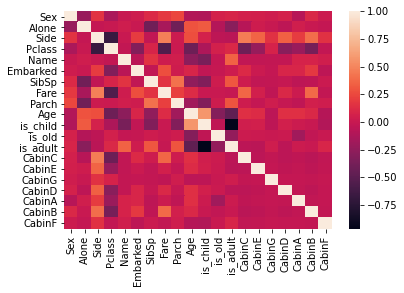

In [179]:
X = create_df(df_train)
Y = df_train.Survived

sns.heatmap(X.corr())

X = np.array(X).transpose()
# X = X / np.linalg.norm(X, ord=2, axis=1, keepdims=True)
Y = np.array(Y).reshape(891, 1)

X_test = create_df(df_test)
X_test = np.array(X_test).transpose()
Y_test = df_gender.Survived
Y_test = np.array(Y_test).reshape((418, 1))

In [180]:
# learning_rates = [0.2, 0.01, 0.05, 0.03]
# num_iter = [30000]
# for learning in learning_rates:
#     for number_iter in num_iter:
#         print(calculate_best_prediction(X, Y, X_test, Y_test, learning,num_it=number_iter))

layer_dimensions = [20, 5, 4, 3, 1]
parameters = dp.L_layer_model(X, Y.transpose(), X_test, Y_test.T, layer_dimensions, learning_rate=0.2 ,num_iterations=40000, print_cost=True)
predict_aux = dp.predict(X_test, Y_test.T, parameters)
print(predict_aux)

## Best results so far [20, 5, 4, 3,  1] 0.2 20598 96,17%

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.665914
Cost after iteration 200: 0.665912
Cost after iteration 300: 0.665912
Cost after iteration 400: 0.665912
Cost after iteration 500: 0.665912
Cost after iteration 600: 0.665912
Cost after iteration 700: 0.665912
Cost after iteration 800: 0.665912
Cost after iteration 900: 0.665912
Cost after iteration 1000: 0.665912
Cost after iteration 1100: 0.665912
Cost after iteration 1200: 0.665912
Cost after iteration 1300: 0.665912
Cost after iteration 1400: 0.665912
Cost after iteration 1500: 0.665912
Cost after iteration 1600: 0.665912
Cost after iteration 1700: 0.665912
Cost after iteration 1800: 0.665912
Cost after iteration 1900: 0.665912
Cost after iteration 2000: 0.665912
Cost after iteration 2100: 0.665912
Cost after iteration 2200: 0.665912
Cost after iteration 2300: 0.665912
Cost after iteration 2400: 0.665912
Cost after iteration 2500: 0.665912
Cost after iteration 2600: 0.665912
Cost after iteration 2700: 0.665912
Cost

KeyboardInterrupt: 